# Spencer Peters
## Project 02

#### Updated 4-29-2021

### Purpose/Abstract

The book that will be mentioned throughout this notebook is Computational Modeling and Visualization of Physical Systems with Python By J. Wang

In this notebook, I will be looking at the Magnus effect on a golf ball. Originally I had planned to model figure 3.17 from the book but soon realized that the data points provided by Dr. Wang did not give me the same results. This leads me to investigate why my results were different, which lead me to realize the only thing that could make it different was my air density since he did not provide that. After realizing this I noticed that the golf ball with a spin of 16000 RPMs was going slightly shorter than the golf ball with a spin rate of half that. With this, I observed that too much lift along with the longer period in the air causes a more significant time for air resistance to doing its work. The first model (model one) below was the attempt at the book's example using three different spin rates (0,8000,16000) RPMs this where I made my first discovery that a greater spin rate does not always mean more distance. Model two (A and B), use a for loop to show increasing effects of air resistance due to excessive lift and the effects. Model Two A is a more realistic approach while Model Two B is a more unrealistic approach to see the huge difference of distance with unrealistic spin rates.

### Theoretical Model

What is the "model"? What are the relevant ODEs and assumptions in your model?
The models below show the Magnus effect with different spin rates with air resistance as well. The RK4 ode is used as well as the Cd and Cl calculation provided in the book by Dr. Wang. Assumptions that were made were air density, the mass of the golf ball, radius of the golf ball, angle of launch, and speed. All of these were given in the book by Dr. Wang except the air density which we assumed, giving us slightly different results than him leading to a deeper investigation
$$C_D = \frac{1}{4}(1 + \frac{1}{1+\exp(2v-12)}) $$
$$C_L = 0.55S^{0.4}$$

### Dr. Wang's Figure 3.17
![ch003-f017.JPG](ch003-f017.JPG)

### Import Statements
Assumes your ode is in the path if not comment out line 2 and uncomment line 1

In [1]:
#import ode #if you have ode.py in the same folder as your notebook
import compy.ode as cp
import numpy as np
import matplotlib.pyplot as plt

### Calculation Functions
This is where the ODE and Magnus functions reside along with the constants such as mass, radius, and gravity. 

In [2]:
def mag(v):
    #calculate magnitude of an array
    return np.sqrt(np.dot(v,v))

def hat(v):
    #calculate unit vector of an array
    return v/mag(v)

def cross(v1,v2):
    #calculate the cross product of two vectors
    return np.cross(v1,v2)

def getCd(v):
    Cd = .25*(1+(1/(1+np.exp(2*v+12))))
    return Cd

def model_magnus(d, tn):        
    #data
    x = d[0]
    y = d[1]
    z = d[2]  
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    #derivatives
    rate = np.zeros(6) #derivatives
    rate[0] = vx
    rate[1] = vy
    rate[2] = vz
    
    #speed
    v = np.array([vx,vy,vz])
    vmag = mag(v)
    
    #calculate force and dv/dt
    Cd=getCd(vmag)
    b2 = 1/2*Cd*rho*A
    
    S = r*omegamag/vmag
    CL = 0.55*S**0.4
    alpha = 1/2*CL*rho*A*r/S
    
    FM = alpha*cross(omega,v) #magnus force
    
    rate[3] = -b2*vmag*vx/m + FM[0]/m
    rate[4] = (-b2*vmag*vy - m*g)/m + FM[1]/m
    rate[5] = (-b2*vmag*vz)/m  + FM[2]/m
    
    return rate

def run_magnus(data): # run simulation with case integer
    global b2, alpha #need to change the value of b2 and alpha
    
    v = data[3:6]
    vmag = mag(v)

    #time
    t = 0
    h= 0.01
    Nsteps = int(10/h)

    #store trajectory for plotting or animation
    traj = np.zeros((Nsteps, 4)) #store t, x, y, z for plotting
    traj[0,:] = np.array([t, x0, y0, z0]) #store initial time and position

    for n in range(0,Nsteps-1):

        #update data
        data = cp.RK4(model_magnus, data, t, h )

        #update t
        t = t + h

        #store data for plotting
        traj[n+1,:] = np.array([t, data[0], data[1], data[2]])
    
    return traj


#parameters
g = 9.8 #N/kg
rho = 1.2 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 0.0215 # 4.3cm diameter
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.046 #kg
b2 = 1/2*Cd*rho*A #will change xas Cd changes

S = 0.01 #will change as omega and v change
CL = 0 #will change with S
alpha = 1/2*CL*rho*A*r/S


### Model One
This is the first model I made which lead to my discovery that spin rate does not always increase distance

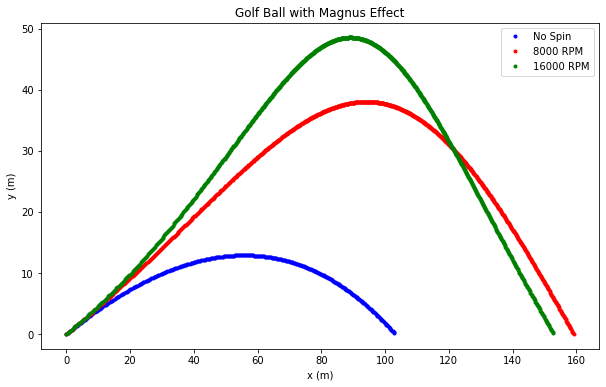

Spin ~0 RPM: range = 103 m
Spin 8000 RPM: range = 159 m 
Spin 16000 RPM: range = 153 m


In [3]:
# data for golf shot
thetadeg = 23 #deg

# convert units and create initial conditions
vmag0 = 45
theta = thetadeg*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
z0 = 0
vx0 = vmag0*np.cos(theta)
vy0 = vmag0*np.sin(theta)
vz0 = 0

# array for instantaneous position and velocity data
d = np.array([x0, y0, z0, vx0, vy0, vz0])

# run models
spinrate = 1e-3 #rpm
omegamag = spinrate * 2*np.pi / 60 #rad/s
omega = np.array([0, 0, omegamag])
traj = run_magnus(d)
traj0 = traj[traj[:,2]>=0] 

spinrate = 8000 #rpm
omegamag = spinrate * 2*np.pi / 60 #rad/s
omega = np.array([0, 0, omegamag])
traj = run_magnus(d)
traj1 = traj[traj[:,2]>=0] 

spinrate = 16000 #rpm
omegamag = spinrate * 2*np.pi / 60 #rad/s
omega = np.array([0, 0, omegamag])
traj = run_magnus(d)
traj2 = traj[traj[:,2]>=0] 


#plot
fig = plt.figure(figsize=(10,6))
plt.title("Golf Ball with Magnus Effect")
plt.plot(traj0[:,1], traj0[:,2], 'b.', label='No Spin')
plt.plot(traj1[:,1], traj1[:,2], 'r.', label='8000 RPM')
plt.plot(traj2[:,1], traj2[:,2], 'g.', label='16000 RPM')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()

range0 = traj0[-1,1]
range1 = traj1[-1,1]
range2 = traj2[-1,1]

print("Spin ~0 RPM: range = {:.0f} m".format(range0))
print("Spin 8000 RPM: range = {:.0f} m ".format(range1))
print("Spin 16000 RPM: range = {:.0f} m".format(range2))

### Model Two A
This model uses semi-realistic spin rates in order to show the effects of air resistance versus spin rate and Magnus effect

Spin 1000: range = 135 m
Spin 2000: range = 144 m
Spin 3000: range = 150 m
Spin 4000: range = 154 m
Spin 5000: range = 156 m
Spin 6000: range = 158 m
Spin 7000: range = 159 m
Spin 8000: range = 159 m
Spin 9000: range = 159 m
Spin 10000: range = 159 m
Spin 11000: range = 158 m
Spin 12000: range = 157 m
Spin 13000: range = 156 m
Spin 14000: range = 155 m


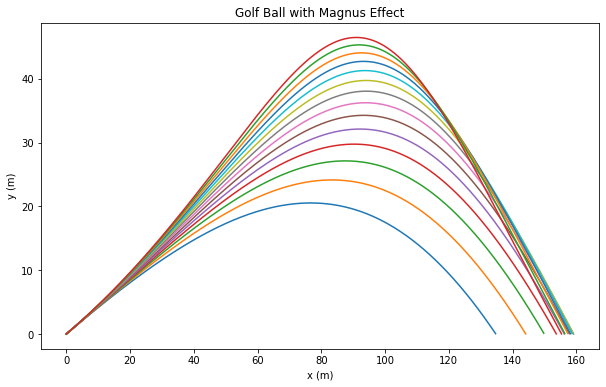

In [4]:
N = 15
fig = plt.figure(figsize=(10,6))
plt.title("Golf Ball with Magnus Effect")

for i in range(1,N):
    spinrate = i*1000 #rpm
    omegamag = spinrate * 2*np.pi / 60 #rad/s
    omega = np.array([0, 0, omegamag])
    traj = run_magnus(d)
    traj3 = traj[traj[:,2]>=0]
    plt.plot(traj3[:,1], traj3[:,2])
    print("Spin {:.0f}: range = {:.0f} m".format(spinrate,traj3[-1,1]))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()    


### Model Two B


Spin 5000: range = 156 m
Spin 10000: range = 159 m
Spin 15000: range = 154 m
Spin 20000: range = 147 m
Spin 25000: range = 139 m
Spin 30000: range = 132 m
Spin 35000: range = 124 m
Spin 40000: range = 117 m
Spin 45000: range = 110 m
Spin 50000: range = 104 m
Spin 55000: range = 98 m
Spin 60000: range = 92 m
Spin 65000: range = 86 m
Spin 70000: range = 81 m


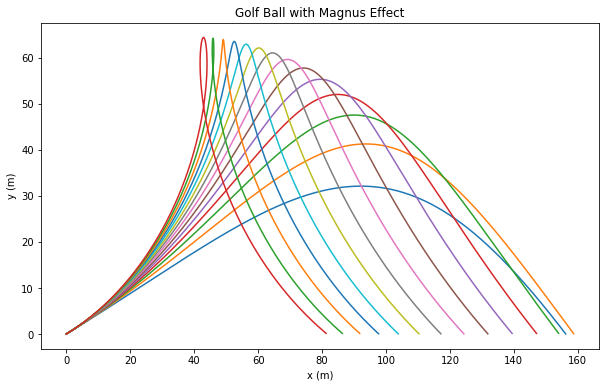

In [5]:
N = 15
fig = plt.figure(figsize=(10,6))
plt.title("Golf Ball with Magnus Effect")

for i in range(1,N):
    spinrate = i*5000 #rpm
    omegamag = spinrate * 2*np.pi / 60 #rad/s
    omega = np.array([0, 0, omegamag])
    traj = run_magnus(d)
    traj3 = traj[traj[:,2]>=0]
    plt.plot(traj3[:,1], traj3[:,2])
    print("Spin {:.0f}: range = {:.0f} m".format(spinrate,traj3[-1,1]))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()    


### Validation
Since my original model did not go as planned i.e perfectly matching the model from the book lead me to investigate why this was happening. Upon further investigation, I realized the only possible thing that may be different between my model and Dr. Wangs is his air density affecting the air resistance. While picking apart my code to find this I was able to validate my ODE's and lift formulas to confirm they were working properly. Based on what we've learned in class and the graphs created I was able to validate my models were working correctly.

### Results/Conclusion
The results of my modeling show how the bigger the spin rate does not always mean more distance. As we can see in Model Two A around spin rate 11000 RPM we see the amount of lift increasing the time of flight. This allows for the effects of air resistance to increase decreasing the overall distance of the ball. In Model Two B we can see this effect even greater as the spin rates get extremely fast sometimes even showing a brief period of travel in the -x direction. In conclusion, the spin rate is not linked to distance in a perfectly linear way but instead, there is a point at which spin rate can negatively affect the distance

### References
Functions were borrowed from the baseball magnus in class example but were modified for the golf ball and with air resistance always a factor (Credit to Dr. Titus and Dr. Wang)
